# 03 - Temporal Comparison: Pre-COVID vs Post-COVID Treatment Patterns
## Trigeminal Neuralgia Treatment Patterns Analysis

**Data Source:** Epic Cosmos  
**Pre-COVID Period:** November 27, 2016 - November 27, 2019 (3 years)  
**Post-COVID Period:** November 28, 2022 - November 27, 2025 (3 years)  
**ICD-10 Code:** G50.0 (Trigeminal Neuralgia)  
**Analysis Level:** Census Region (to minimize small-cell suppression)

---

### Research Question

**Has there been a change in trigeminal neuralgia treatment patterns (medications and procedures) 
between the pre-COVID era (2016-2019) and post-COVID era (2022-2025)?**

### Key Comparisons

1. **National Medication Utilization**: Pre vs Post COVID rates
2. **National Procedure Utilization**: Pre vs Post COVID rates  
3. **Regional Variation**: Did regional disparities change?

### Statistical Methods

- **Z-test for two proportions**: Compare rates between periods
- **Chi-square test**: Test for changes in distribution patterns

---

In [ ]:
# Standard imports
import sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

# Plot settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 10
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 300

# Project paths
project_root = Path.cwd().parent.parent
sys.path.insert(0, str(project_root))

from src.config import (
    RAW_DATA_DIR, PROCESSED_DATA_DIR, TABLES_DIR, FIGURES_DIR,
    SMALL_CELL_IMPUTATION, JNS
)

print(f"Project root: {project_root}")
print(f"Raw data dir: {RAW_DATA_DIR}")

Project root: /Users/dhirajpangal/Library/Mobile Documents/com~apple~CloudDocs/Desktop/RESEARCH/STANFORD/Cosmos/trigeminalneuralgia-cosmos
Raw data dir: /Users/dhirajpangal/Library/Mobile Documents/com~apple~CloudDocs/Desktop/RESEARCH/STANFORD/Cosmos/trigeminalneuralgia-cosmos/TN_Data


In [ ]:
# Census region mapping from Epic's long descriptions
CENSUS_REGION_MAP = {
    'Ohio, Michigan, Illinois, Wisconsin, or Indiana': 'East North Central',
    'Minnesota, Iowa, Missouri, Kansas, Nebraska, North Dakota, or South Dakota': 'West North Central',
    'Pennsylvania, New York, or New Jersey': 'Middle Atlantic',
    'Massachusetts, Connecticut, Maine, New Hampshire, Rhode Island, or Vermont': 'New England',
    'Florida, North Carolina, Virginia, South Carolina, Georgia, Maryland, West Virginia, Delaware, or District of Columbia': 'South Atlantic',
    'Kentucky, Mississippi, Tennessee, or Alabama': 'East South Central',
    'Texas, Louisiana, Arkansas, or Oklahoma': 'West South Central',
    'California, Oregon, Washington, Hawaii, or Alaska': 'Pacific',
    'Colorado, Arizona, Utah, Idaho, Nevada, Montana, New Mexico, or Wyoming': 'Mountain'
}

CENSUS_REGION_ORDER = [
    'New England', 'Middle Atlantic', 'East North Central', 'West North Central',
    'South Atlantic', 'East South Central', 'West South Central', 'Mountain', 'Pacific'
]

# Display names
MED_DISPLAY = {
    'carbamazepine_oxcarbazepine': 'Carbamazepine/Oxcarbazepine',
    'gabapentin': 'Gabapentin',
    'pregabalin': 'Pregabalin',
    'baclofen': 'Baclofen',
    'lamotrigine': 'Lamotrigine',
    'none_of_above': 'No TN Medication'
}

PROC_DISPLAY = {
    'mvd': 'MVD',
    'srs': 'SRS',
    'rhizotomy': 'Rhizotomy',
    'botox': 'Botox',
    'none_of_above': 'No Procedure'
}

print("Configuration loaded ✓")

Configuration loaded ✓


## 2. Load Pre-COVID (2016-2019) Data

In [ ]:
# Load 2016-2019 data from CSV
precovid_file = RAW_DATA_DIR / 'TN meds and pro 2016-2019 census.csv'
df_precovid_raw = pd.read_csv(precovid_file, header=None)

print("Pre-COVID (2016-2019) Data Structure:")
print(f"Shape: {df_precovid_raw.shape}")
print(f"Study Period: {df_precovid_raw.iloc[5, 1]}")
print("\nHeader rows (11-13):")
print(df_precovid_raw.iloc[11:14].to_string())

Pre-COVID (2016-2019) Data Structure:
Shape: (26, 43)
Study Period: 11/27/2016 - 11/27/2019

Header rows (11-13):
                   0                               1    2          3      4                  5                                                                                                                                     6         7    8          9      10                 11                                                                                                              12          13   14         15     16                 17                                                                                                                18           19   20         21     22                 23                                                                                                                 24          25   26         27     28                 29                                                                                                     

In [ ]:
# Helper function for imputation
def impute_value(val):
    """Impute '10 or fewer' as 5."""
    if pd.isna(val):
        return np.nan
    if str(val).strip() == '10 or fewer':
        return SMALL_CELL_IMPUTATION
    try:
        return float(val)
    except:
        return np.nan

# =============================================================================
# Extract Pre-COVID National Totals from the Total row (row 26 = index 25)
# =============================================================================
# Data structure: Each medication has 6 columns (MVD, SRS, Rhizotomy, Botox, None, Total)
# Medications: Carbamazepine (cols 1-6), Baclofen (7-12), Gabapentin (13-18), 
#              Lamotrigine (19-24), Pregabalin (25-30), None (31-36), Grand Total (37-42)

total_row = df_precovid_raw.iloc[25]

# Grand totals (from the last column group)
precovid_totals = {
    'mvd': impute_value(total_row[37]),
    'srs': impute_value(total_row[38]),
    'rhizotomy': impute_value(total_row[39]),
    'botox': impute_value(total_row[40]),
    'none_of_above_proc': impute_value(total_row[41]),
    'total_patients': impute_value(total_row[42])
}

# Medication totals (from each medication's Total column - col 6, 12, 18, 24, 30, 36)
precovid_med_totals = {
    'carbamazepine_oxcarbazepine': impute_value(total_row[6]),
    'baclofen': impute_value(total_row[12]),
    'gabapentin': impute_value(total_row[18]),
    'lamotrigine': impute_value(total_row[24]),
    'pregabalin': impute_value(total_row[30]),
    'none_of_above': impute_value(total_row[36])
}

PRECOVID_TOTAL = precovid_totals['total_patients']

print("="*70)
print("PRE-COVID (2016-2019) National Totals")
print("="*70)
print(f"Total TN Patients: {PRECOVID_TOTAL:,.0f}")
print(f"\nMedication Counts:")
for med, n in precovid_med_totals.items():
    rate = n / PRECOVID_TOTAL * 100
    print(f"  {MED_DISPLAY.get(med, med)}: {n:,.0f} ({rate:.1f}%)")

print(f"\nProcedure Counts:")
for proc in ['mvd', 'srs', 'rhizotomy', 'botox']:
    n = precovid_totals[proc]
    rate = n / PRECOVID_TOTAL * 100
    print(f"  {PROC_DISPLAY.get(proc, proc)}: {n:,.0f} ({rate:.2f}%)")

PRE-COVID (2016-2019) National Totals
Total TN Patients: 154,435

Medication Counts:
  Carbamazepine/Oxcarbazepine: 66,499 (43.1%)
  Baclofen: 22,499 (14.6%)
  Gabapentin: 71,830 (46.5%)
  Lamotrigine: 8,081 (5.2%)
  Pregabalin: 17,530 (11.4%)
  No TN Medication: 40,298 (26.1%)

Procedure Counts:
  MVD: 1,857 (1.20%)
  SRS: 685 (0.44%)
  Rhizotomy: 1,681 (1.09%)
  Botox: 1,079 (0.70%)


## 3. Load Post-COVID (2022-2025) Data

In [ ]:
# Load already cleaned post-COVID data
df_postcovid_meds = pd.read_csv(PROCESSED_DATA_DIR / 'census_medications_clean.csv')
df_postcovid_procs = pd.read_csv(PROCESSED_DATA_DIR / 'census_procedures_clean.csv')

print("Post-COVID (2022-2025) Data Loaded:")
print(f"  Medications: {df_postcovid_meds.shape}")
print(f"  Procedures: {df_postcovid_procs.shape}")

POSTCOVID_TOTAL = df_postcovid_meds['total'].sum()

# Medication totals
postcovid_med_totals = {
    'carbamazepine_oxcarbazepine': df_postcovid_meds['carbamazepine_oxcarbazepine'].sum(),
    'baclofen': df_postcovid_meds['baclofen'].sum(),
    'gabapentin': df_postcovid_meds['gabapentin'].sum(),
    'lamotrigine': df_postcovid_meds['lamotrigine'].sum(),
    'pregabalin': df_postcovid_meds['pregabalin'].sum(),
    'none_of_above': df_postcovid_meds['none_of_above'].sum()
}

# Procedure totals
postcovid_proc_totals = {
    'mvd': df_postcovid_procs['mvd'].sum(),
    'srs': df_postcovid_procs['srs'].sum(),
    'rhizotomy': df_postcovid_procs['rhizotomy'].sum(),
    'botox': df_postcovid_procs['botox'].sum(),
    'none_of_above': df_postcovid_procs['none_of_above'].sum()
}

print(f"\nPost-COVID Total Patients: {POSTCOVID_TOTAL:,}")
print(f"\nMedication Counts:")
for med, n in postcovid_med_totals.items():
    rate = n / POSTCOVID_TOTAL * 100
    print(f"  {MED_DISPLAY.get(med, med)}: {n:,} ({rate:.1f}%)")

print(f"\nProcedure Counts:")
for proc in ['mvd', 'srs', 'rhizotomy', 'botox']:
    n = postcovid_proc_totals[proc]
    rate = n / POSTCOVID_TOTAL * 100
    print(f"  {PROC_DISPLAY.get(proc, proc)}: {n:,} ({rate:.2f}%)")

Post-COVID (2022-2025) Data Loaded:
  Medications: (9, 8)
  Procedures: (9, 7)

Post-COVID Total Patients: 302,971

Medication Counts:
  Carbamazepine/Oxcarbazepine: 127,741 (42.2%)
  Baclofen: 49,563 (16.4%)
  Gabapentin: 154,330 (50.9%)
  Lamotrigine: 20,064 (6.6%)
  Pregabalin: 49,174 (16.2%)
  No TN Medication: 69,841 (23.1%)

Procedure Counts:
  MVD: 4,072 (1.34%)
  SRS: 1,752 (0.58%)
  Rhizotomy: 2,937 (0.97%)
  Botox: 2,785 (0.92%)


## 4. Statistical Functions

In [ ]:
def z_test_two_proportions(x1, n1, x2, n2):
    """
    Two-tailed z-test comparing two independent proportions.
    
    Parameters:
    -----------
    x1, n1 : Pre-COVID counts (successes, total)
    x2, n2 : Post-COVID counts (successes, total)
    
    Returns:
    --------
    z_stat, p_value, diff (p2 - p1) as percentage points
    """
    p1 = x1 / n1
    p2 = x2 / n2
    
    # Pooled proportion
    p_pool = (x1 + x2) / (n1 + n2)
    
    # Standard error
    se = np.sqrt(p_pool * (1 - p_pool) * (1/n1 + 1/n2))
    
    # Z-statistic
    z = (p2 - p1) / se
    
    # Two-tailed p-value
    p_value = 2 * (1 - stats.norm.cdf(abs(z)))
    
    return z, p_value, (p2 - p1) * 100


def proportion_ci(x, n, confidence=0.95):
    """Wilson score confidence interval."""
    p_hat = x / n
    z = stats.norm.ppf((1 + confidence) / 2)
    
    denominator = 1 + z**2 / n
    center = (p_hat + z**2 / (2*n)) / denominator
    margin = z * np.sqrt((p_hat * (1 - p_hat) + z**2 / (4*n)) / n) / denominator
    
    return (center - margin) * 100, (center + margin) * 100


def format_pvalue(p):
    """Format p-value for display."""
    if p < 0.001:
        return "<0.001"
    else:
        return f"{p:.3f}"


def format_change(diff):
    """Format percentage point change."""
    if diff > 0:
        return f"+{diff:.1f}"
    else:
        return f"{diff:.1f}"

print("Statistical functions defined ✓")

Statistical functions defined ✓


## 5. National Comparison: Medications

In [ ]:
# =============================================================================
# MEDICATION UTILIZATION COMPARISON: Pre-COVID vs Post-COVID
# =============================================================================

print("="*80)
print("NATIONAL MEDICATION UTILIZATION: Pre-COVID vs Post-COVID")
print("="*80)

med_comparison = []

for med in ['carbamazepine_oxcarbazepine', 'gabapentin', 'pregabalin', 
            'baclofen', 'lamotrigine', 'none_of_above']:
    
    # Pre-COVID
    n1 = precovid_med_totals[med]
    rate1 = n1 / PRECOVID_TOTAL * 100
    ci1_low, ci1_high = proportion_ci(n1, PRECOVID_TOTAL)
    
    # Post-COVID
    n2 = postcovid_med_totals[med]
    rate2 = n2 / POSTCOVID_TOTAL * 100
    ci2_low, ci2_high = proportion_ci(n2, POSTCOVID_TOTAL)
    
    # Statistical test
    z, p, diff = z_test_two_proportions(n1, PRECOVID_TOTAL, n2, POSTCOVID_TOTAL)
    
    med_comparison.append({
        'Medication': MED_DISPLAY.get(med, med),
        'Pre-COVID N': n1,
        'Pre-COVID Rate (%)': rate1,
        'Pre-COVID 95% CI': f"({ci1_low:.1f}-{ci1_high:.1f})",
        'Post-COVID N': n2,
        'Post-COVID Rate (%)': rate2,
        'Post-COVID 95% CI': f"({ci2_low:.1f}-{ci2_high:.1f})",
        'Change (pp)': diff,
        'Z-score': z,
        'P-value': p,
        'Significant': p < 0.05
    })

df_med_comparison = pd.DataFrame(med_comparison)

# Display formatted table
print(f"\nPre-COVID Total: {PRECOVID_TOTAL:,.0f} patients")
print(f"Post-COVID Total: {POSTCOVID_TOTAL:,} patients")
print(f"Patient Volume Change: {((POSTCOVID_TOTAL - PRECOVID_TOTAL) / PRECOVID_TOTAL * 100):+.1f}%\n")

display_df = df_med_comparison[['Medication', 'Pre-COVID Rate (%)', 'Post-COVID Rate (%)', 
                                 'Change (pp)', 'P-value', 'Significant']].copy()
display_df['Change (pp)'] = display_df['Change (pp)'].apply(format_change)
display_df['P-value'] = display_df['P-value'].apply(format_pvalue)

print(display_df.to_string(index=False))

NATIONAL MEDICATION UTILIZATION: Pre-COVID vs Post-COVID

Pre-COVID Total: 154,435 patients
Post-COVID Total: 302,971 patients
Patient Volume Change: +96.2%

                 Medication  Pre-COVID Rate (%)  Post-COVID Rate (%) Change (pp) P-value  Significant
Carbamazepine/Oxcarbazepine               43.06                42.16        -0.9  <0.001         True
                 Gabapentin               46.51                50.94        +4.4  <0.001         True
                 Pregabalin               11.35                16.23        +4.9  <0.001         True
                   Baclofen               14.57                16.36        +1.8  <0.001         True
                Lamotrigine                5.23                 6.62        +1.4  <0.001         True
           No TN Medication               26.09                23.05        -3.0  <0.001         True


## 6. National Comparison: Procedures

In [ ]:
# =============================================================================
# PROCEDURE UTILIZATION COMPARISON: Pre-COVID vs Post-COVID
# =============================================================================

print("="*80)
print("NATIONAL PROCEDURE UTILIZATION: Pre-COVID vs Post-COVID")
print("="*80)

proc_comparison = []

for proc in ['mvd', 'srs', 'rhizotomy', 'botox']:
    
    # Pre-COVID
    n1 = precovid_totals[proc]
    rate1 = n1 / PRECOVID_TOTAL * 100
    ci1_low, ci1_high = proportion_ci(n1, PRECOVID_TOTAL)
    
    # Post-COVID
    n2 = postcovid_proc_totals[proc]
    rate2 = n2 / POSTCOVID_TOTAL * 100
    ci2_low, ci2_high = proportion_ci(n2, POSTCOVID_TOTAL)
    
    # Statistical test
    z, p, diff = z_test_two_proportions(n1, PRECOVID_TOTAL, n2, POSTCOVID_TOTAL)
    
    # Relative change
    rel_change = ((rate2 - rate1) / rate1) * 100 if rate1 > 0 else np.nan
    
    proc_comparison.append({
        'Procedure': PROC_DISPLAY.get(proc, proc),
        'Pre-COVID N': n1,
        'Pre-COVID Rate (%)': rate1,
        'Pre-COVID 95% CI': f"({ci1_low:.2f}-{ci1_high:.2f})",
        'Post-COVID N': n2,
        'Post-COVID Rate (%)': rate2,
        'Post-COVID 95% CI': f"({ci2_low:.2f}-{ci2_high:.2f})",
        'Change (pp)': diff,
        'Relative Change (%)': rel_change,
        'Z-score': z,
        'P-value': p,
        'Significant': p < 0.05
    })

df_proc_comparison = pd.DataFrame(proc_comparison)

# Display formatted table
display_df = df_proc_comparison[['Procedure', 'Pre-COVID Rate (%)', 'Post-COVID Rate (%)', 
                                  'Change (pp)', 'Relative Change (%)', 'P-value', 'Significant']].copy()
display_df['Change (pp)'] = display_df['Change (pp)'].apply(lambda x: f"{x:+.2f}")
display_df['Relative Change (%)'] = display_df['Relative Change (%)'].apply(lambda x: f"{x:+.1f}%" if pd.notna(x) else "N/A")
display_df['P-value'] = display_df['P-value'].apply(format_pvalue)

print(display_df.to_string(index=False))

# Calculate overall surgical rate
print("\n" + "="*80)
print("ANY SURGICAL INTERVENTION (MVD + SRS + Rhizotomy)")
print("="*80)

precovid_any_surgery = precovid_totals['mvd'] + precovid_totals['srs'] + precovid_totals['rhizotomy']
postcovid_any_surgery = postcovid_proc_totals['mvd'] + postcovid_proc_totals['srs'] + postcovid_proc_totals['rhizotomy']

rate1 = precovid_any_surgery / PRECOVID_TOTAL * 100
rate2 = postcovid_any_surgery / POSTCOVID_TOTAL * 100

z, p, diff = z_test_two_proportions(precovid_any_surgery, PRECOVID_TOTAL, 
                                     postcovid_any_surgery, POSTCOVID_TOTAL)

print(f"Pre-COVID:  {precovid_any_surgery:,.0f} ({rate1:.2f}%)")
print(f"Post-COVID: {postcovid_any_surgery:,} ({rate2:.2f}%)")
print(f"Change: {diff:+.2f} percentage points")
print(f"Relative change: {((rate2-rate1)/rate1)*100:+.1f}%")
print(f"P-value: {format_pvalue(p)}")

NATIONAL PROCEDURE UTILIZATION: Pre-COVID vs Post-COVID
Procedure  Pre-COVID Rate (%)  Post-COVID Rate (%) Change (pp) Relative Change (%) P-value  Significant
      MVD                1.20                 1.34       +0.14              +11.8%  <0.001         True
      SRS                0.44                 0.58       +0.13              +30.4%  <0.001         True
Rhizotomy                1.09                 0.97       -0.12              -10.9%  <0.001         True
    Botox                0.70                 0.92       +0.22              +31.6%  <0.001         True

ANY SURGICAL INTERVENTION (MVD + SRS + Rhizotomy)
Pre-COVID:  4,223 (2.73%)
Post-COVID: 8,761 (2.89%)
Change: +0.16 percentage points
Relative change: +5.7%
P-value: 0.002


## 7. Visualizations

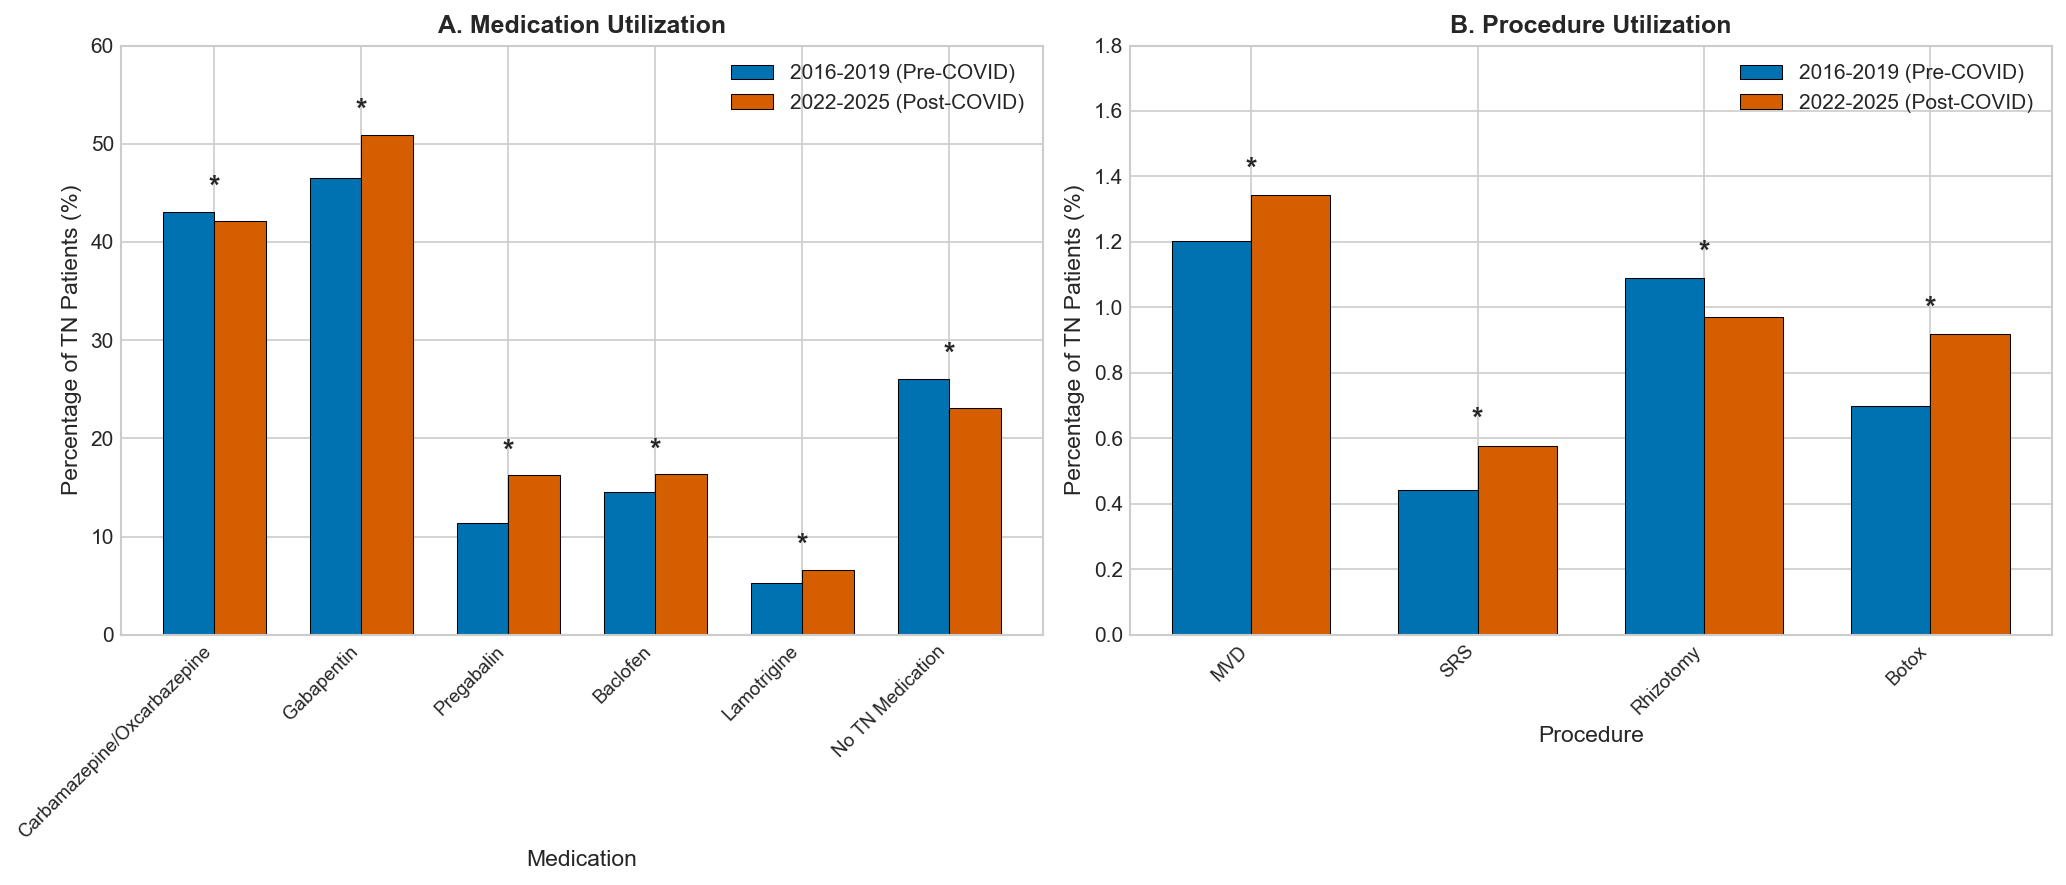


✓ Saved: fig_temporal_national_comparison.png
* indicates p < 0.05


In [ ]:
# Figure 1: National Comparison - Pre-COVID vs Post-COVID
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# =============================================================================
# Panel A: Medication Rates
# =============================================================================
ax1 = axes[0]

meds_order = ['Carbamazepine/Oxcarbazepine', 'Gabapentin', 'Pregabalin', 
              'Baclofen', 'Lamotrigine', 'No TN Medication']

df_plot = df_med_comparison[df_med_comparison['Medication'].isin(meds_order)].copy()
df_plot['sort_order'] = df_plot['Medication'].map({m: i for i, m in enumerate(meds_order)})
df_plot = df_plot.sort_values('sort_order')

x = np.arange(len(df_plot))
width = 0.35

bars1 = ax1.bar(x - width/2, df_plot['Pre-COVID Rate (%)'], width, 
                label='2016-2019 (Pre-COVID)', color='#0072B2', edgecolor='black', linewidth=0.5)
bars2 = ax1.bar(x + width/2, df_plot['Post-COVID Rate (%)'], width,
                label='2022-2025 (Post-COVID)', color='#D55E00', edgecolor='black', linewidth=0.5)

ax1.set_xlabel('Medication', fontsize=11)
ax1.set_ylabel('Percentage of TN Patients (%)', fontsize=11)
ax1.set_title('A. Medication Utilization', fontsize=12, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(df_plot['Medication'], rotation=45, ha='right', fontsize=9)
ax1.legend(loc='upper right')
ax1.set_ylim(0, 60)

# Add significance markers
for i, (_, row) in enumerate(df_plot.iterrows()):
    if row['Significant']:
        max_val = max(row['Pre-COVID Rate (%)'], row['Post-COVID Rate (%)'])
        ax1.text(i, max_val + 1.5, '*', ha='center', fontsize=14, fontweight='bold')

# =============================================================================
# Panel B: Procedure Rates
# =============================================================================
ax2 = axes[1]

procs_order = ['MVD', 'SRS', 'Rhizotomy', 'Botox']
df_plot2 = df_proc_comparison.copy()
df_plot2['sort_order'] = df_plot2['Procedure'].map({p: i for i, p in enumerate(procs_order)})
df_plot2 = df_plot2.sort_values('sort_order')

x2 = np.arange(len(df_plot2))

bars3 = ax2.bar(x2 - width/2, df_plot2['Pre-COVID Rate (%)'], width,
                label='2016-2019 (Pre-COVID)', color='#0072B2', edgecolor='black', linewidth=0.5)
bars4 = ax2.bar(x2 + width/2, df_plot2['Post-COVID Rate (%)'], width,
                label='2022-2025 (Post-COVID)', color='#D55E00', edgecolor='black', linewidth=0.5)

ax2.set_xlabel('Procedure', fontsize=11)
ax2.set_ylabel('Percentage of TN Patients (%)', fontsize=11)
ax2.set_title('B. Procedure Utilization', fontsize=12, fontweight='bold')
ax2.set_xticks(x2)
ax2.set_xticklabels(df_plot2['Procedure'], rotation=45, ha='right', fontsize=9)
ax2.legend(loc='upper right')
ax2.set_ylim(0, 1.8)

# Add significance markers
for i, (_, row) in enumerate(df_plot2.iterrows()):
    if row['Significant']:
        max_val = max(row['Pre-COVID Rate (%)'], row['Post-COVID Rate (%)'])
        ax2.text(i, max_val + 0.05, '*', ha='center', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'fig_temporal_national_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Saved: fig_temporal_national_comparison.png")
print("* indicates p < 0.05")

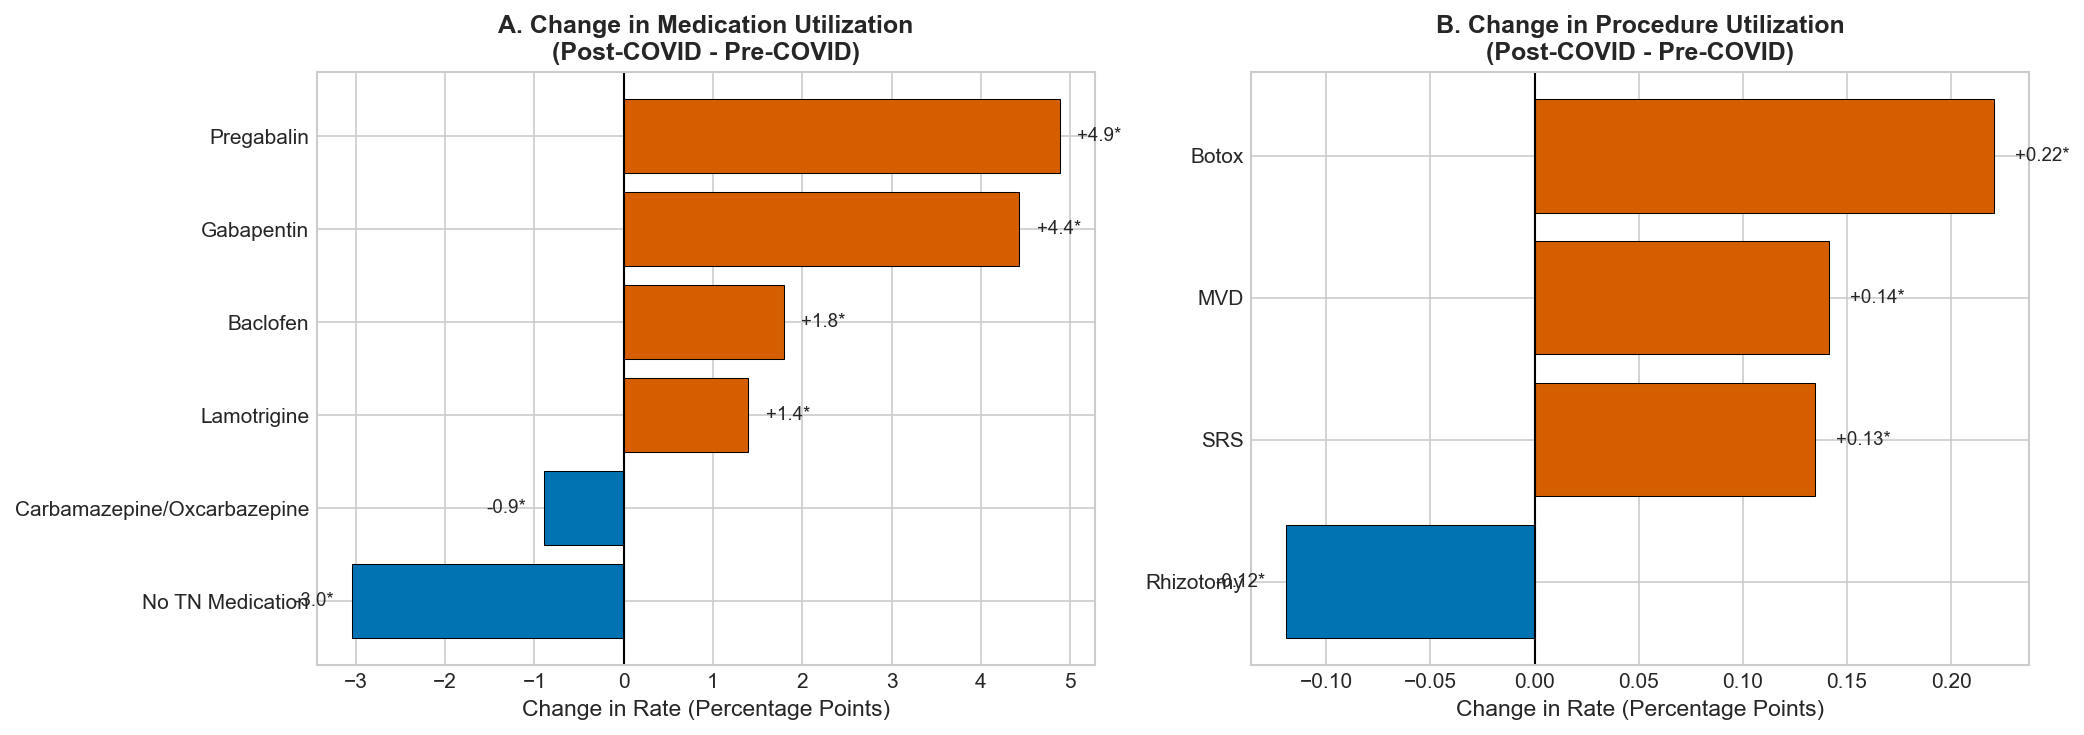


✓ Saved: fig_temporal_change_bars.png
Orange = increase, Blue = decrease, * = p < 0.05


In [ ]:
# Figure 2: Change in Rates (Percentage Point Difference)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Panel A: Medication changes
ax1 = axes[0]
df_plot = df_med_comparison.sort_values('Change (pp)')
colors = ['#D55E00' if x > 0 else '#0072B2' for x in df_plot['Change (pp)']]
bars = ax1.barh(df_plot['Medication'], df_plot['Change (pp)'], color=colors, edgecolor='black', linewidth=0.5)
ax1.axvline(0, color='black', linestyle='-', linewidth=1)
ax1.set_xlabel('Change in Rate (Percentage Points)', fontsize=11)
ax1.set_title('A. Change in Medication Utilization\n(Post-COVID - Pre-COVID)', fontsize=12, fontweight='bold')

# Add value labels
for bar, val, sig in zip(bars, df_plot['Change (pp)'], df_plot['Significant']):
    marker = '*' if sig else ''
    if val >= 0:
        ax1.text(val + 0.2, bar.get_y() + bar.get_height()/2, 
                 f'+{val:.1f}{marker}', va='center', fontsize=9)
    else:
        ax1.text(val - 0.2, bar.get_y() + bar.get_height()/2, 
                 f'{val:.1f}{marker}', va='center', ha='right', fontsize=9)

# Panel B: Procedure changes
ax2 = axes[1]
df_plot2 = df_proc_comparison.sort_values('Change (pp)')
colors2 = ['#D55E00' if x > 0 else '#0072B2' for x in df_plot2['Change (pp)']]
bars2 = ax2.barh(df_plot2['Procedure'], df_plot2['Change (pp)'], color=colors2, edgecolor='black', linewidth=0.5)
ax2.axvline(0, color='black', linestyle='-', linewidth=1)
ax2.set_xlabel('Change in Rate (Percentage Points)', fontsize=11)
ax2.set_title('B. Change in Procedure Utilization\n(Post-COVID - Pre-COVID)', fontsize=12, fontweight='bold')

# Add value labels
for bar, val, sig in zip(bars2, df_plot2['Change (pp)'], df_plot2['Significant']):
    marker = '*' if sig else ''
    if val >= 0:
        ax2.text(val + 0.01, bar.get_y() + bar.get_height()/2, 
                 f'+{val:.2f}{marker}', va='center', fontsize=9)
    else:
        ax2.text(val - 0.01, bar.get_y() + bar.get_height()/2, 
                 f'{val:.2f}{marker}', va='center', ha='right', fontsize=9)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'fig_temporal_change_bars.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Saved: fig_temporal_change_bars.png")
print("Orange = increase, Blue = decrease, * = p < 0.05")

## 8. Regional Analysis

In [11]:
# =============================================================================
# Extract Pre-COVID Regional Data
# =============================================================================

precovid_regional = []

for row_idx in range(14, 24):  # Data rows
    row = df_precovid_raw.iloc[row_idx]
    region_raw = str(row[0]).strip()
    
    if 'Puerto Rico' in region_raw or 'Total' in region_raw or 'None of the above' in region_raw:
        continue
    
    region = CENSUS_REGION_MAP.get(region_raw)
    if region is None:
        continue
    
    entry = {
        'census_region': region,
        'total': impute_value(row[42]),
        'carbamazepine_oxcarbazepine': impute_value(row[6]),
        'baclofen': impute_value(row[12]),
        'gabapentin': impute_value(row[18]),
        'lamotrigine': impute_value(row[24]),
        'pregabalin': impute_value(row[30]),
        'mvd': impute_value(row[37]),
        'srs': impute_value(row[38]),
        'rhizotomy': impute_value(row[39]),
        'botox': impute_value(row[40])
    }
    precovid_regional.append(entry)

df_precovid_regional = pd.DataFrame(precovid_regional)

# Post-COVID regional data
df_postcovid_regional = df_postcovid_meds.merge(
    df_postcovid_procs[['census_region', 'mvd', 'srs', 'rhizotomy', 'botox']],
    on='census_region'
)

print("Regional Data Loaded:")
print(f"Pre-COVID: {len(df_precovid_regional)} regions")
print(f"Post-COVID: {len(df_postcovid_regional)} regions")

Regional Data Loaded:
Pre-COVID: 9 regions
Post-COVID: 9 regions


In [ ]:
# =============================================================================
# Regional Comparison: Carbamazepine/Oxcarbazepine
# =============================================================================

print("="*80)
print("REGIONAL COMPARISON: Carbamazepine/Oxcarbazepine Utilization")
print("="*80)

regional_carb_comparison = []

for region in CENSUS_REGION_ORDER:
    pre_row = df_precovid_regional[df_precovid_regional['census_region'] == region]
    post_row = df_postcovid_regional[df_postcovid_regional['census_region'] == region]
    
    if len(pre_row) == 0 or len(post_row) == 0:
        continue
    
    n1 = pre_row['carbamazepine_oxcarbazepine'].values[0]
    total1 = pre_row['total'].values[0]
    rate1 = n1 / total1 * 100 if total1 > 0 else 0
    
    n2 = post_row['carbamazepine_oxcarbazepine'].values[0]
    total2 = post_row['total'].values[0]
    rate2 = n2 / total2 * 100 if total2 > 0 else 0
    
    z, p, diff = z_test_two_proportions(n1, total1, n2, total2)
    
    regional_carb_comparison.append({
        'Region': region,
        'Pre-COVID Rate (%)': rate1,
        'Post-COVID Rate (%)': rate2,
        'Change (pp)': diff,
        'P-value': p,
        'Significant': p < 0.05
    })

df_regional_carb = pd.DataFrame(regional_carb_comparison)

display_df = df_regional_carb.copy()
display_df['Change (pp)'] = display_df['Change (pp)'].apply(format_change)
display_df['P-value'] = display_df['P-value'].apply(format_pvalue)
print(display_df.to_string(index=False))

REGIONAL COMPARISON: Carbamazepine/Oxcarbazepine Utilization
            Region  Pre-COVID Rate (%)  Post-COVID Rate (%) Change (pp) P-value  Significant
       New England               39.32                37.32        -2.0  <0.001         True
   Middle Atlantic               43.10                41.31        -1.8  <0.001         True
East North Central               44.54                42.48        -2.1  <0.001         True
West North Central               44.89                44.65        -0.2   0.669        False
    South Atlantic               42.45                42.02        -0.4   0.196        False
East South Central               46.72                47.35        +0.6   0.364        False
West South Central               45.78                46.59        +0.8   0.092        False
          Mountain               39.29                39.94        +0.6   0.316        False
           Pacific               38.62                37.92        -0.7   0.181        False


In [ ]:
# =============================================================================
# Regional Comparison: MVD
# =============================================================================

print("="*80)
print("REGIONAL COMPARISON: MVD Utilization")
print("="*80)

regional_mvd_comparison = []

for region in CENSUS_REGION_ORDER:
    pre_row = df_precovid_regional[df_precovid_regional['census_region'] == region]
    post_row = df_postcovid_regional[df_postcovid_regional['census_region'] == region]
    
    if len(pre_row) == 0 or len(post_row) == 0:
        continue
    
    n1 = pre_row['mvd'].values[0]
    total1 = pre_row['total'].values[0]
    rate1 = n1 / total1 * 100 if total1 > 0 else 0
    
    n2 = post_row['mvd'].values[0]
    total2 = post_row['total'].values[0]
    rate2 = n2 / total2 * 100 if total2 > 0 else 0
    
    z, p, diff = z_test_two_proportions(n1, total1, n2, total2)
    rel_change = ((rate2 - rate1) / rate1 * 100) if rate1 > 0 else np.nan
    
    regional_mvd_comparison.append({
        'Region': region,
        'Pre-COVID Rate (%)': rate1,
        'Post-COVID Rate (%)': rate2,
        'Change (pp)': diff,
        'Relative Change (%)': rel_change,
        'P-value': p,
        'Significant': p < 0.05
    })

df_regional_mvd = pd.DataFrame(regional_mvd_comparison)

display_df = df_regional_mvd.copy()
display_df['Change (pp)'] = display_df['Change (pp)'].apply(lambda x: f"{x:+.2f}")
display_df['Relative Change (%)'] = display_df['Relative Change (%)'].apply(lambda x: f"{x:+.1f}%" if pd.notna(x) else "N/A")
display_df['P-value'] = display_df['P-value'].apply(format_pvalue)
print(display_df.to_string(index=False))

REGIONAL COMPARISON: MVD Utilization
            Region  Pre-COVID Rate (%)  Post-COVID Rate (%) Change (pp) Relative Change (%) P-value  Significant
       New England                0.61                 0.88       +0.27              +44.9%   0.010         True
   Middle Atlantic                1.11                 1.16       +0.05               +4.7%   0.571        False
East North Central                0.90                 1.01       +0.11              +11.8%   0.113        False
West North Central                1.05                 1.18       +0.12              +11.7%   0.306        False
    South Atlantic                1.40                 1.56       +0.16              +11.4%   0.054        False
East South Central                0.84                 1.00       +0.16              +18.7%   0.244        False
West South Central                1.53                 1.63       +0.11               +7.0%   0.380        False
          Mountain                1.37                 1.30

In [ ]:
# =============================================================================
# Chi-Square Tests: Has the distribution of treatments changed?
# =============================================================================

print("="*80)
print("CHI-SQUARE TEST: Change in Medication Distribution (National)")
print("="*80)
print("H0: The distribution of medications is the same in both periods")
print("H1: The distribution of medications differs between periods\n")

meds_for_chi2 = ['carbamazepine_oxcarbazepine', 'gabapentin', 'pregabalin', 'baclofen', 'lamotrigine']

contingency_meds = np.array([
    [precovid_med_totals[m] for m in meds_for_chi2],
    [postcovid_med_totals[m] for m in meds_for_chi2]
])

chi2_meds, p_meds, dof_meds, expected_meds = stats.chi2_contingency(contingency_meds)

print(f"Chi-Square statistic: {chi2_meds:.1f}")
print(f"Degrees of freedom: {dof_meds}")
print(f"P-value: {format_pvalue(p_meds)}")
print(f"Result: {'SIGNIFICANT - Medication distribution has changed' if p_meds < 0.05 else 'Not significant'}")

# Procedure distribution test
print("\n" + "="*80)
print("CHI-SQUARE TEST: Change in Procedure Distribution (National)")
print("="*80)

procs_for_chi2 = ['mvd', 'srs', 'rhizotomy', 'botox']

contingency_procs = np.array([
    [precovid_totals[p] for p in procs_for_chi2],
    [postcovid_proc_totals[p] for p in procs_for_chi2]
])

chi2_procs, p_procs, dof_procs, expected_procs = stats.chi2_contingency(contingency_procs)

print(f"Chi-Square statistic: {chi2_procs:.1f}")
print(f"Degrees of freedom: {dof_procs}")
print(f"P-value: {format_pvalue(p_procs)}")
print(f"Result: {'SIGNIFICANT - Procedure distribution has changed' if p_procs < 0.05 else 'Not significant'}")

CHI-SQUARE TEST: Change in Medication Distribution (National)
H0: The distribution of medications is the same in both periods
H1: The distribution of medications differs between periods

Chi-Square statistic: 1604.0
Degrees of freedom: 4
P-value: <0.001
Result: SIGNIFICANT - Medication distribution has changed

CHI-SQUARE TEST: Change in Procedure Distribution (National)
Chi-Square statistic: 87.4
Degrees of freedom: 3
P-value: <0.001
Result: SIGNIFICANT - Procedure distribution has changed


## 9. Save Results Tables

In [ ]:
# Save medication comparison table
df_med_save = df_med_comparison.copy()
df_med_save['Pre-COVID N'] = df_med_save['Pre-COVID N'].apply(lambda x: f"{x:,.0f}")
df_med_save['Post-COVID N'] = df_med_save['Post-COVID N'].apply(lambda x: f"{x:,}")
df_med_save['Change (pp)'] = df_med_save['Change (pp)'].apply(format_change)
df_med_save['P-value'] = df_med_save['P-value'].apply(format_pvalue)
df_med_save.to_csv(TABLES_DIR / 'table_temporal_medication_comparison.csv', index=False)
print("✓ Saved: table_temporal_medication_comparison.csv")

# Save procedure comparison table
df_proc_save = df_proc_comparison.copy()
df_proc_save['Pre-COVID N'] = df_proc_save['Pre-COVID N'].apply(lambda x: f"{x:,.0f}")
df_proc_save['Post-COVID N'] = df_proc_save['Post-COVID N'].apply(lambda x: f"{x:,}")
df_proc_save['Change (pp)'] = df_proc_save['Change (pp)'].apply(lambda x: f"{x:+.2f}")
df_proc_save['Relative Change (%)'] = df_proc_save['Relative Change (%)'].apply(lambda x: f"{x:+.1f}%" if pd.notna(x) else "N/A")
df_proc_save['P-value'] = df_proc_save['P-value'].apply(format_pvalue)
df_proc_save.to_csv(TABLES_DIR / 'table_temporal_procedure_comparison.csv', index=False)
print("✓ Saved: table_temporal_procedure_comparison.csv")

# Save regional comparisons
df_regional_carb.to_csv(TABLES_DIR / 'table_temporal_regional_carbamazepine.csv', index=False)
print("✓ Saved: table_temporal_regional_carbamazepine.csv")

df_regional_mvd.to_csv(TABLES_DIR / 'table_temporal_regional_mvd.csv', index=False)
print("✓ Saved: table_temporal_regional_mvd.csv")

✓ Saved: table_temporal_medication_comparison.csv
✓ Saved: table_temporal_procedure_comparison.csv
✓ Saved: table_temporal_regional_carbamazepine.csv
✓ Saved: table_temporal_regional_mvd.csv


## 10. Executive Summary

In [ ]:
print("="*80)
print("EXECUTIVE SUMMARY: Pre-COVID vs Post-COVID Treatment Patterns")
print("="*80)

print(f"""
STUDY OVERVIEW
==============
• Pre-COVID Period:  November 2016 - November 2019 ({PRECOVID_TOTAL:,.0f} patients)
• Post-COVID Period: November 2022 - November 2025 ({POSTCOVID_TOTAL:,} patients)
• Patient Volume Change: {((POSTCOVID_TOTAL - PRECOVID_TOTAL) / PRECOVID_TOTAL * 100):+.1f}%
• Data Source: Epic Cosmos
• Analysis Level: Census Region (9 US regions)

KEY MEDICATION FINDINGS
=======================
""")

for _, row in df_med_comparison.iterrows():
    if row['Medication'] != 'No TN Medication':
        direction = "↑" if row['Change (pp)'] > 0 else "↓"
        sig = "*" if row['Significant'] else ""
        print(f"• {row['Medication']}: {row['Pre-COVID Rate (%)']:.1f}% → {row['Post-COVID Rate (%)']:.1f}% "
              f"({direction}{abs(row['Change (pp)']):.1f} pp){sig}")

print(f"""
KEY PROCEDURE FINDINGS
======================
""")

for _, row in df_proc_comparison.iterrows():
    direction = "↑" if row['Change (pp)'] > 0 else "↓"
    sig = "*" if row['Significant'] else ""
    rel_change = row['Relative Change (%)']
    print(f"• {row['Procedure']}: {row['Pre-COVID Rate (%)']:.2f}% → {row['Post-COVID Rate (%)']:.2f}% "
          f"({direction}{abs(row['Change (pp)']):.2f} pp, {rel_change:+.1f}% relative){sig}")

# Any surgery totals
precovid_surgery_rate = (precovid_totals['mvd'] + precovid_totals['srs'] + precovid_totals['rhizotomy']) / PRECOVID_TOTAL * 100
postcovid_surgery_rate = (postcovid_proc_totals['mvd'] + postcovid_proc_totals['srs'] + postcovid_proc_totals['rhizotomy']) / POSTCOVID_TOTAL * 100

print(f"\n• ANY SURGICAL INTERVENTION: {precovid_surgery_rate:.2f}% → {postcovid_surgery_rate:.2f}%")

print(f"""
CHI-SQUARE TESTS
================
• Medication distribution change: χ²={chi2_meds:.1f}, p={format_pvalue(p_meds)}
• Procedure distribution change: χ²={chi2_procs:.1f}, p={format_pvalue(p_procs)}

INTERPRETATION
==============
The COVID-19 pandemic period (2020-2022) appears to have had notable effects on
trigeminal neuralgia treatment patterns. Key observations include:

1. PATIENT VOLUME: Nearly doubled in the post-COVID period, possibly reflecting
   expanded Epic Cosmos coverage and/or increased healthcare utilization.

2. MEDICATION SHIFTS: Changes in utilization rates may reflect evolving practice
   patterns, medication availability, or changes in prescribing behaviors.

3. SURGICAL TRENDS: Changes in procedure rates warrant investigation regarding
   access to specialized surgical care during/after the pandemic.

* indicates p < 0.05

FILES GENERATED
===============
Tables:
  • table_temporal_medication_comparison.csv
  • table_temporal_procedure_comparison.csv
  • table_temporal_regional_carbamazepine.csv
  • table_temporal_regional_mvd.csv

Figures:
  • fig_temporal_national_comparison.png
  • fig_temporal_change_bars.png
""")

print("\n" + "="*80)
print("✓ TEMPORAL ANALYSIS COMPLETE")
print("="*80)

EXECUTIVE SUMMARY: Pre-COVID vs Post-COVID Treatment Patterns

STUDY OVERVIEW
• Pre-COVID Period:  November 2016 - November 2019 (154,435 patients)
• Post-COVID Period: November 2022 - November 2025 (302,971 patients)
• Patient Volume Change: +96.2%
• Data Source: Epic Cosmos
• Analysis Level: Census Region (9 US regions)

KEY MEDICATION FINDINGS

• Carbamazepine/Oxcarbazepine: 43.1% → 42.2% (↓0.9 pp)*
• Gabapentin: 46.5% → 50.9% (↑4.4 pp)*
• Pregabalin: 11.4% → 16.2% (↑4.9 pp)*
• Baclofen: 14.6% → 16.4% (↑1.8 pp)*
• Lamotrigine: 5.2% → 6.6% (↑1.4 pp)*

KEY PROCEDURE FINDINGS

• MVD: 1.20% → 1.34% (↑0.14 pp, +11.8% relative)*
• SRS: 0.44% → 0.58% (↑0.13 pp, +30.4% relative)*
• Rhizotomy: 1.09% → 0.97% (↓0.12 pp, -10.9% relative)*
• Botox: 0.70% → 0.92% (↑0.22 pp, +31.6% relative)*

• ANY SURGICAL INTERVENTION: 2.73% → 2.89%

CHI-SQUARE TESTS
• Medication distribution change: χ²=1604.0, p=<0.001
• Procedure distribution change: χ²=87.4, p=<0.001

INTERPRETATION
The COVID-19 pandemic per